In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [3]:
img_object = cv.imread('ach_template.png', cv.IMREAD_GRAYSCALE)
mask = np.zeros((img_object.shape[0],img_object.shape[1]), np.uint8)
#TODO: Save start_pt, end_pt into an XML/JSON file. Read it when needed.
start_pt = (80, 200)
end_pt = (1550, 1550)
cv.rectangle(mask, start_pt, end_pt, 255, -1)
img_scene = cv.imread('testimg1.jpg', cv.IMREAD_GRAYSCALE)

In [4]:
def get_homography(img_object, img_scene, mask, draw=False):
    # find the homography matrix H
    detector = cv.xfeatures2d.SIFT_create()
    keypoints_obj, descriptors_obj = detector.detectAndCompute(img_object,mask, None)
    keypoints_scene, descriptors_scene = detector.detectAndCompute(img_scene, None)
    #-- Step 2: Matching descriptor vectors with a FLANN based matcher
    # Since SURF is a floating-point descriptor NORM_L2 is used
    matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
    knn_matches = matcher.knnMatch(descriptors_obj, descriptors_scene, 2)
    #-- Filter matches using the Lowe's ratio test
    ratio_thresh = 0.75
    good_matches = []
    for m,n in knn_matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    #-- Draw matches
    img_matches = np.empty((max(img_object.shape[0], img_scene.shape[0]), img_object.shape[1]+img_scene.shape[1], 3), dtype=np.uint8)
    cv.drawMatches(img_object, keypoints_obj, img_scene, keypoints_scene, good_matches, img_matches, )
    #-- Localize the object
    obj = np.empty((len(good_matches),2), dtype=np.float32)
    scene = np.empty((len(good_matches),2), dtype=np.float32)
    for i in range(len(good_matches)):
        #-- Get the keypoints from the good matches
        obj[i,0] = keypoints_obj[good_matches[i].queryIdx].pt[0]
        obj[i,1] = keypoints_obj[good_matches[i].queryIdx].pt[1]
        scene[i,0] = keypoints_scene[good_matches[i].trainIdx].pt[0]
        scene[i,1] = keypoints_scene[good_matches[i].trainIdx].pt[1]
    H, _ =  cv.findHomography(obj, scene, cv.RANSAC)
    #-- Get the corners from the image_1 ( the object to be "detected" )
    obj_corners = np.empty((4,1,2), dtype=np.float32)
    obj_corners[0,0,0] = 0
    obj_corners[0,0,1] = 0
    obj_corners[1,0,0] = img_object.shape[1]
    obj_corners[1,0,1] = 0
    obj_corners[2,0,0] = img_object.shape[1]
    obj_corners[2,0,1] = img_object.shape[0]
    obj_corners[3,0,0] = 0
    obj_corners[3,0,1] = img_object.shape[0]
    print("obj: ", obj_corners)
    scene_corners = cv.perspectiveTransform(obj_corners, H)
    print("scene:", scene_corners)
    if draw:
        #-- Draw lines between the corners (the mapped object in the scene - image_2 )
        cv.line(img_matches, (int(scene_corners[0,0,0] + img_object.shape[1]), int(scene_corners[0,0,1])),\
            (int(scene_corners[1,0,0] + img_object.shape[1]), int(scene_corners[1,0,1])), (0,255,0), 4)
        cv.line(img_matches, (int(scene_corners[1,0,0] + img_object.shape[1]), int(scene_corners[1,0,1])),\
            (int(scene_corners[2,0,0] + img_object.shape[1]), int(scene_corners[2,0,1])), (0,255,0), 4)
        cv.line(img_matches, (int(scene_corners[2,0,0] + img_object.shape[1]), int(scene_corners[2,0,1])),\
            (int(scene_corners[3,0,0] + img_object.shape[1]), int(scene_corners[3,0,1])), (0,255,0), 4)
        cv.line(img_matches, (int(scene_corners[3,0,0] + img_object.shape[1]), int(scene_corners[3,0,1])),\
            (int(scene_corners[0,0,0] + img_object.shape[1]), int(scene_corners[0,0,1])), (0,255,0), 4)
        #-- Show detected matches
#         img_matches_s = cv.resize(img_matches, (640, 720)) 
#         cv.imshow('Good Matches & Object detection', img_matches)
#         cv.waitKey()
    return H, scene_corners, img_matches
    

In [5]:
H , scene_corners, img_match = get_homography(img_object, img_scene, mask, True)

obj:  [[[   0.    0.]]

 [[1654.    0.]]

 [[1654. 2339.]]

 [[   0. 2339.]]]
scene: [[[ 353.08163  249.12732]]

 [[2757.9622   246.12471]]

 [[2745.4717  3724.7    ]]

 [[ 281.62247 3657.8484 ]]]


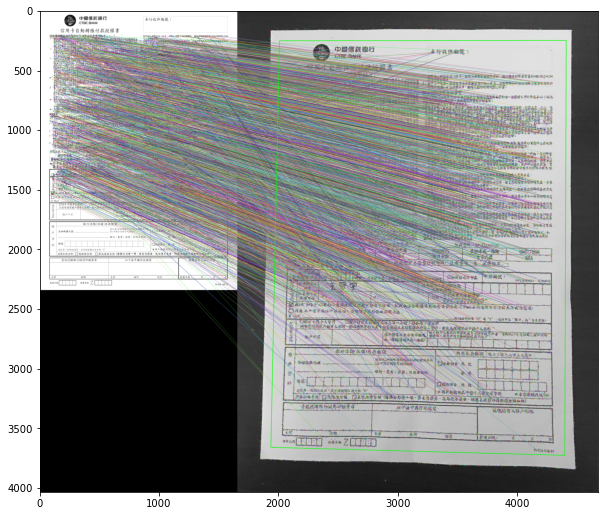

In [6]:
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(img_match)

In [7]:
def make_obj_corner(img):
    obj_corners = np.empty((4,1,2), dtype=np.float32)
    obj_corners[0,0,0] = 0
    obj_corners[0,0,1] = 0
    obj_corners[1,0,0] = img.shape[1]
    obj_corners[1,0,1] = 0
    obj_corners[2,0,0] = img.shape[1]
    obj_corners[2,0,1] = img.shape[0]
    obj_corners[3,0,0] = 0
    obj_corners[3,0,1] = img.shape[0]
    return obj_corners

### Use inverse of homography to detransform the image

In [8]:
img_scene = cv.imread('testimg1.jpg', cv.IMREAD_GRAYSCALE)
homography_inverse = np.linalg.inv(H)
obj_corners = make_obj_corner(img_scene)
img1_warp = cv.warpPerspective(img_scene, homography_inverse, (img_scene.shape[1], img_scene.shape[0]))

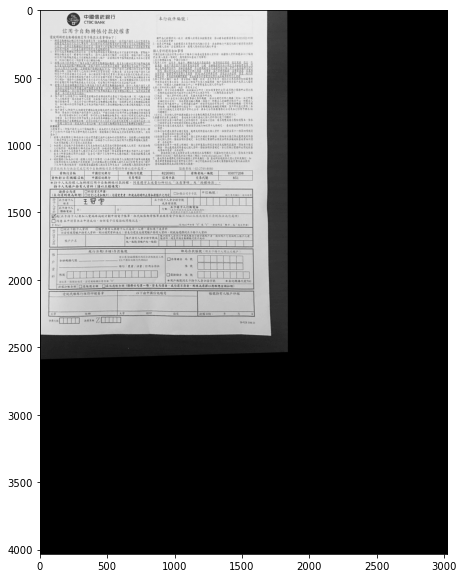

In [9]:
plt.imshow(img1_warp, cmap="gray")

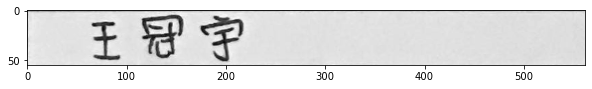

In [10]:
name_space = img1_warp[1390:1445, 258:820]
plt.imshow(name_space, cmap="gray")

In [11]:
name_space.shape

(55, 562)

### Preprocessing on "Name" space

In [12]:
def remove_corner_lines(img):
    # operates on binary image
    height = img.shape[0]
    width = img.shape[1]
    
    print("height: ", height, " width: ", width)
    #vertical top-down top
    for i in range(int(height/4)):
        num_zeros = np.count_nonzero(img[i,:]==0)
        if num_zeros > (width/2):
            img[i,:] = np.full((width,), 255)
        if num_zeros <= int(width/4):
            break
            
    #vertical top-down bot
    for i in range(int(height * 3/4), height):
        num_zeros = np.count_nonzero(img[i,:]==0)   
        if num_zeros > int(width/2):
            img[i,:] = np.full((width,), 255)
        if num_zeros == 0:
            break
            
    #horizontal left-right left
    for i in range(int(width/6)):
        num_zeros = np.count_nonzero(img[:,i]==0)   
        if num_zeros > (height/2):
            img[:,i] = np.full((height,), 255)
        if num_zeros == 0:
            break
    
    #horizontal left-right right
    for i in range(int(width* 5/6), width):
        num_zeros = np.count_nonzero(img[:,i]==0)
        if num_zeros > (height/2):
            img[:,i] = np.full((height,), 255)
        if num_zeros == 0:
            break
    return img
        


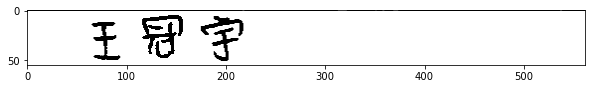

In [13]:
#Make binary image
__, name_space_binary = cv.threshold(name_space,127,255,cv.THRESH_BINARY)
plt.imshow(name_space_binary, cmap="gray")

height:  55  width:  562


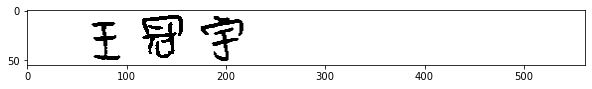

In [14]:
# Remove corner black lines
name_space_binary = remove_corner_lines(name_space_binary)
plt.imshow(name_space_binary, cmap="gray")

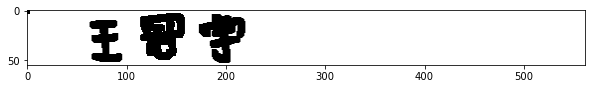

In [15]:
# Morphological manipulation (Opening) to make connected parts
kernel = np.ones((5,5),np.uint8)
erosion = cv.erode(name_space_binary,kernel,iterations = 1)
cleared = cv.dilate(erosion,kernel,iterations = 1)
plt.imshow(erosion, cmap="gray")

### Label connected parts with red rectangle

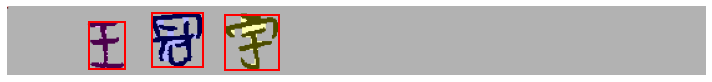

In [16]:
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import matplotlib.patches as mpatches
from skimage.measure import label

label_image = label(255 - cleared)
# plt.imshow(label_image, cmap="gray")

image_label_overlay = label2rgb(label_image, image=name_space_binary, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)
rectangles = []
for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 200:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rectangles.append([(minc, minr), maxc - minc, maxr - minr])
        
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

### Crop and save Chinese characters

In [56]:
final_size = 100
chars = []
for rect in rectangles:
    coord = rect[0]
    x_0 = coord[0]
    y_0 = coord[1]
    char_width = rect[1]
    char_height = rect[2]


    char = name_space_binary[y_0: y_0 + char_height, x_0: x_0 + char_width]
    chars.append(char)

    

In [93]:
def resize_to_100(img):
    img = img.copy()
    width = img.shape[1]
    height = img.shape[0]
    horizontal_pad = final_size - width
    vertical_pad = final_size - height
    print("i shape: ", img.shape)
    print("v: ", vertical_pad)
    print("h: ", horizontal_pad)
    inter = cv.INTER_AREA
    
    if horizontal_pad < 0:
        #resize
        dim = (100, height)
        img = cv.resize(img, dim, interpolation = inter)
    
    elif (horizontal_pad % 2) == 0:
        lr_pad = horizontal_pad // 2
        img = cv.copyMakeBorder(img,0,0,lr_pad,lr_pad,cv.BORDER_CONSTANT, value=(255))
        
    else:
        #odd
        l_pad = horizontal_pad // 2
        r_pad = l_pad + 1
        img = cv.copyMakeBorder(img,0,0,l_pad,r_pad,cv.BORDER_CONSTANT,value=(255))
        
    if vertical_pad < 0:
        dim = (width, 100)
        img = cv.resize(img, dim, interpolation = inter)
    
    elif (vertical_pad % 2) == 0:
        tb_pad = vertical_pad // 2
        img = cv.copyMakeBorder(img,tb_pad,tb_pad,0,0,cv.BORDER_CONSTANT,value=(255))
    
    else:
        t_pad = vertical_pad // 2
        b_pad = t_pad + 1
        img = cv.copyMakeBorder(img,t_pad,b_pad,0,0,cv.BORDER_CONSTANT,value= (0))
    
    return img        
        


In [94]:
resized = []
for char_img in chars:
    resized.append(resize_to_100(char_img))

i shape:  (43, 41)
v:  57
h:  59
i shape:  (45, 43)
v:  55
h:  57
i shape:  (38, 29)
v:  62
h:  71


In [95]:
for i, img in enumerate(resized):
    cv.imwrite("example_{}.png".format(i), img)

i shape:  (43, 41)
v:  57
h:  59


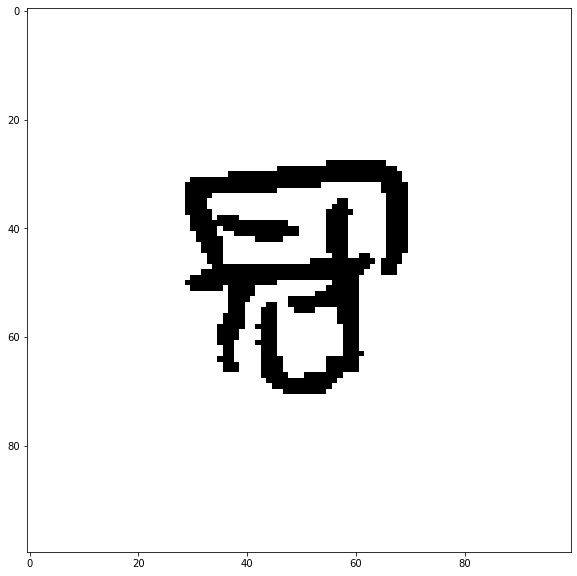

In [96]:
one = resize_to_100(chars[0])
plt.imshow(one, cmap="gray")

# Pass these images to DNN!